In [18]:
# ==================================
#    CELDA [1]: LIBRERÍAS Y FUNCIONES
# ==================================

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para Supresión de No-Máximos
def non_max_suppression(grad_magnitude, grad_direction):
    """
    grad_magnitude: matriz con la magnitud del gradiente
    grad_direction: matriz con la dirección del gradiente en radianes

    Retorna:
        suppressed: matriz con los valores de grad_magnitude donde sólo
                    se conservan los máximos locales en la dirección del gradiente.
                    El resto se pone a 0.
    """
    rows, cols = grad_magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.float32)

    # Convertimos la dirección de radianes a grados
    direction_degrees = grad_direction * 180.0 / np.pi
    # Ajustamos a [0,180)
    direction_degrees[direction_degrees < 0] += 180

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            angle = direction_degrees[i, j]
            mag = grad_magnitude[i, j]

            # Vectores vecinos según el ángulo
            if (0 <= angle < 22.5) or (157.5 <= angle < 180):
                neighbor1 = grad_magnitude[i, j-1]
                neighbor2 = grad_magnitude[i, j+1]
            elif (22.5 <= angle < 67.5):
                neighbor1 = grad_magnitude[i-1, j+1]
                neighbor2 = grad_magnitude[i+1, j-1]
            elif (67.5 <= angle < 112.5):
                neighbor1 = grad_magnitude[i-1, j]
                neighbor2 = grad_magnitude[i+1, j]
            else:  # (112.5 <= angle < 157.5)
                neighbor1 = grad_magnitude[i-1, j-1]
                neighbor2 = grad_magnitude[i+1, j+1]

            if (mag >= neighbor1) and (mag >= neighbor2):
                suppressed[i, j] = mag
            else:
                suppressed[i, j] = 0.0

    return suppressed

# Función para Doble Umbral + Histéresis
def double_threshold_hysteresis(img_nms, low_ratio=0.05, high_ratio=0.15):
    """
    img_nms: imagen tras la supresión de no-máximos (valores de magnitud).
    low_ratio, high_ratio: proporciones para calcular umbrales.

    Retorna:
        edges_final: imagen binaria con los bordes finales (0 o 255).
    """
    max_mag = np.max(img_nms)
    high_thresh = high_ratio * max_mag
    low_thresh = low_ratio * max_mag

    rows, cols = img_nms.shape
    edges_final = np.zeros((rows, cols), dtype=np.uint8)

    # Clasificación inicial
    strong_i, strong_j = np.where(img_nms >= high_thresh)
    weak_i, weak_j = np.where((img_nms >= low_thresh) & (img_nms < high_thresh))

    edges_final[strong_i, strong_j] = 255   # Bordes fuertes
    edges_final[weak_i, weak_j] = 50        # Bordes débiles

    # Conexión de débiles con fuertes (8-conectividad)
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if edges_final[i, j] == 50:  # débil
                if 255 in edges_final[i-1:i+2, j-1:j+2]:
                    edges_final[i, j] = 255
                else:
                    edges_final[i, j] = 0

    return edges_final


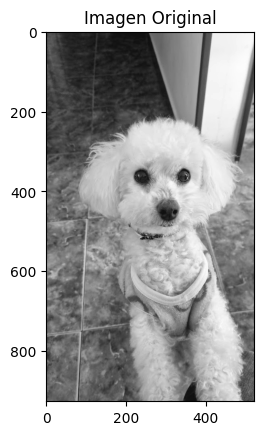

In [19]:
# ==================================
#  CELDA [2]: CARGAR Y MOSTRAR IMAGEN
# ==================================

# Ruta de tu imagen
image_path = "Janis.jpg"  # <-- Ajusta aquí el nombre/ruta de tu imagen

# Leer en escala de grises
img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img_gray is None:
    print("No se pudo cargar la imagen. Verifica la ruta/nombre.")
else:
    plt.figure()
    plt.title("Imagen Original")
    plt.imshow(img_gray, cmap='gray')
    plt.show()


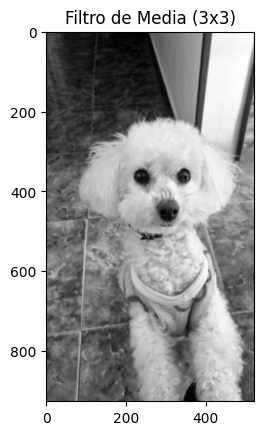

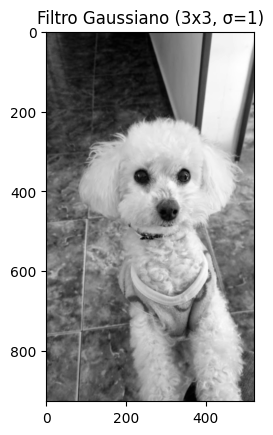

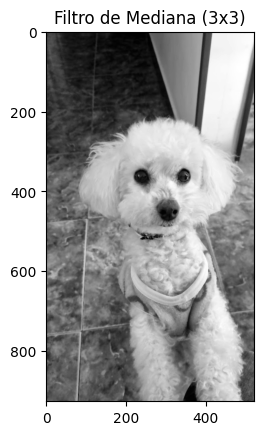

In [22]:
# ====================================================
#  CELDA [3]: FILTROS DE SUAVIZADO: MEDIA, GAUSSIANO, MEDIANA
# ====================================================

if img_gray is not None:
    # Filtro de Media
    mean_blur = cv2.blur(img_gray, (3, 3))

    plt.figure()
    plt.title("Filtro de Media (3x3)")
    plt.imshow(mean_blur, cmap='gray')
    plt.show()

    # Filtro Gaussiano
    gauss_blur = cv2.GaussianBlur(img_gray, (3, 3), 1)

    plt.figure()
    plt.title("Filtro Gaussiano (3x3, σ=1)")
    plt.imshow(gauss_blur, cmap='gray')
    plt.show()

    # Filtro Mediana
    median_blur = cv2.medianBlur(img_gray, 3)

    plt.figure()
    plt.title("Filtro de Mediana (3x3)")
    plt.imshow(median_blur, cmap='gray')
    plt.show()


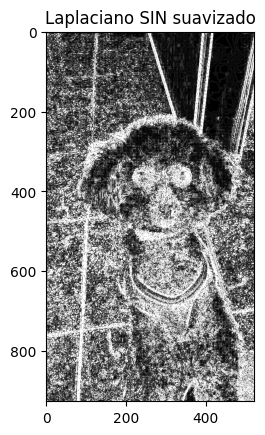

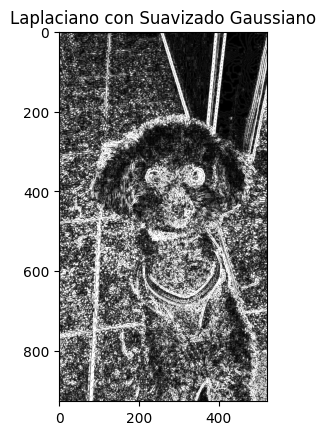

In [23]:
# ==========================================
#  CELDA [5]: LAPLACIANO CON Y SIN SUAVIZADO
# ==========================================

if img_gray is not None:
    # Laplaciano SIN suavizado
    lap_no_smooth = cv2.Laplacian(img_gray, cv2.CV_32F, ksize=5)
    lap_no_smooth_abs = cv2.convertScaleAbs(lap_no_smooth)

    plt.figure()
    plt.title("Laplaciano SIN suavizado")
    plt.imshow(lap_no_smooth_abs, cmap='gray')
    plt.show()

    # Laplaciano CON suavizado (p.ej. Gaussiano)
    lap_smooth = cv2.Laplacian(gauss_blur, cv2.CV_32F, ksize=5)
    lap_smooth_abs = cv2.convertScaleAbs(lap_smooth)

    plt.figure()
    plt.title("Laplaciano con Suavizado Gaussiano")
    plt.imshow(lap_smooth_abs, cmap='gray')
    plt.show()


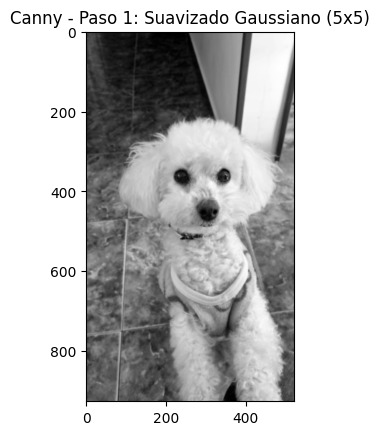

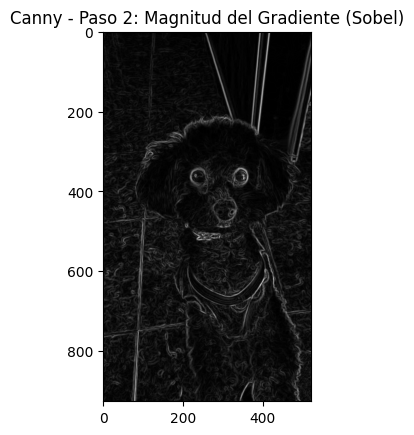

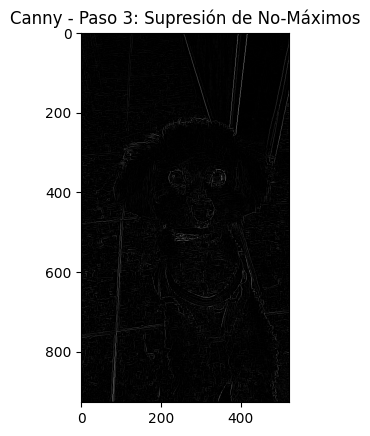

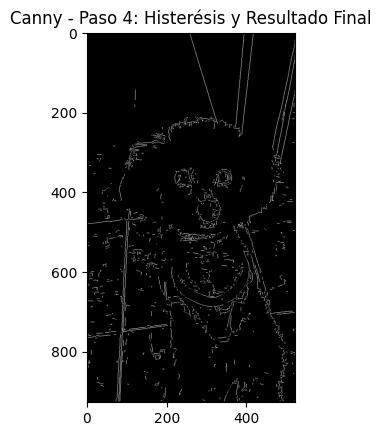

In [33]:
# =====================================================================
#  CELDA [6]: CANNY PASO A PASO (suavizado -> gradiente -> NMS -> histéresis)
# =====================================================================

if img_gray is not None:
    # 1) Suavizado Gaussiano (5x5)
    blurred_for_canny = cv2.GaussianBlur(img_gray, (5, 5), 1)
    plt.figure()
    plt.title("Canny - Paso 1: Suavizado Gaussiano (5x5)")
    plt.imshow(blurred_for_canny, cmap='gray')
    plt.show()

    # 2) Gradiente (Sobel)
    sobel_canny_x = cv2.Sobel(blurred_for_canny, cv2.CV_64F, 1, 0, ksize=3)
    sobel_canny_y = cv2.Sobel(blurred_for_canny, cv2.CV_64F, 0, 1, ksize=3)

    grad_magnitude = np.sqrt(sobel_canny_x**2 + sobel_canny_y**2)
    grad_direction = np.arctan2(sobel_canny_y, sobel_canny_x)

    plt.figure()
    plt.title("Canny - Paso 2: Magnitud del Gradiente (Sobel)")
    plt.imshow(grad_magnitude, cmap='gray')
    plt.show()

    # 3) Supresión de No-Máximos
    nms_result = non_max_suppression(grad_magnitude, grad_direction)
    plt.figure()
    plt.title("Canny - Paso 3: Supresión de No-Máximos")
    plt.imshow(nms_result, cmap='gray')
    plt.show()

    # 4) Doble umbral e histéresis
    canny_final = double_threshold_hysteresis(nms_result, 0.05, 0.2)
    plt.figure()
    plt.title("Canny - Paso 4: Histerésis y Resultado Final")
    plt.imshow(canny_final, cmap='gray')
    plt.show()
